> - Author: lebhoryi@gmail.com
> - Date  : 2020/07/09
> - File  : mnist with tensorflow 2 

# Mnist 实验代码

**实验步骤：**

0. 环境搭建## 0. 环境搭建
1. 准备数据集
2. 构建模型
3. 训练
4. 模型预测
5. 模型保存

## 0. 环境搭建

In [1]:
# !pip uninstall tensorflow -y
# !pip install tensorflow

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers, datasets, utils
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
print(f"The tensorflow version is : {tf.__version__}\n")
print(f"The numpy version is : {np.__version__}")

The tensorflow version is : 2.5.0

The numpy version is : 1.19.5


In [3]:
# 创建两个文件夹，存放数据和模型
_list = ['data', 'model']

# 赋值为 Path 对象
dirs = list(map(lambda x: Path(x), _list))
# 假如没有文件夹就创建
for path in dirs:
    if not path.exists():
        path.mkdir()

data_path, model_path = dirs

## 1. 准备数据集

载入并准备好[ MNIST 数据集](http://yann.lecun.com/exdb/mnist/)。

训练集包含60,000个示例图像，测试集包含10,000个示例图像

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data(data_path.resolve()/'mnist.npz')

print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")

x_train shape : (60000, 28, 28)
y_train shape : (60000,)


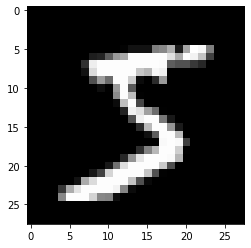

In [5]:
plt.imshow(x_train[0], cmap='gray')
# plt.savefig('./image/tes_2.jpg')
plt.show()

In [6]:
# Normalize data，将图像的像素值都处理到[0,1]范围
x_train, x_test = x_train / 255, x_test / 255
print(f"x_train shape : {x_train.shape}")

x_train, x_test = tf.expand_dims(x_train, -1), tf.expand_dims(x_test, -1)
print(f"add dim x_train shape : {x_train.shape}")

x_train shape : (60000, 28, 28)
add dim x_train shape : (60000, 28, 28, 1)


## 2. 搭建神经网络模型

下面的是 tensorflow 官方例程，*此处不应用*

```python
# build network
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.summary()
```


In [7]:
# build network
tf.keras.backend.clear_session()

model = models.Sequential()
# conv1
model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=4, 
    kernel_size=(3, 3), activation='relu', name='conv1'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool1'))

# conv2
model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), 
                        activation='relu', name='conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool2'))

# flattern
# model.add(layers.Dropout(rate=0.5, name='dropout'))
model.add(layers.Flatten(name='flatten'))

# FC1
model.add(layers.Dense(128, activation='relu', name='FC1'))

# FC2
model.add(layers.Dense(10, activation='softmax', name="FC2"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 4)         40        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 13, 13, 4)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 8)         296       
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               25728     
_________________________________________________________________
FC2 (Dense)                  (None, 10)                1

In [8]:
# # save model image
# utils.plot_model(model, to_file='model.png', show_shapes=True,
#         show_layer_names=True, rankdir='TB', dpi=100, expand_nested=True)

# # save model txt
# with open(model_path/'model.txt', 'wt') as fd:
#     str_list = []
#     model.summary(print_fn=lambda x:str_list.append(x))
#     model_summary = '\n'.join(str_list)
#     fd.write(model_summary)

## 3. 训练

### `compile()` 方法：指定损失、指标和优化器

要使用 `fit()` 训练模型，您需要指定损失函数、优化器以及一些要监视的指标（可选）。

将它们作为 `compile()` 方法的参数传递给模型：

In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy',])
history = model.fit(x_train, y_train, batch_size=128, epochs=3)

Epoch 1/3
469/469 [==============================] - 4s 7ms/step - loss: 0.4339 - accuracy: 0.8793
Epoch 2/3
469/469 [==============================] - 4s 8ms/step - loss: 0.1275 - accuracy: 0.9619
Epoch 3/3
469/469 [==============================] - 4s 8ms/step - loss: 0.0960 - accuracy: 0.9707


In [10]:
# 返回的“历史”对象保留训练期间的损失值和指标值记录
history.history

{'loss': [0.4338635206222534, 0.1275392323732376, 0.09597313404083252],
 'accuracy': [0.8792833089828491, 0.9619333148002625, 0.9706666469573975]}

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
313/313 [==============================] - 1s 2ms/step - loss: 0.0717 - accuracy: 0.9787
test loss, test acc: [0.07172499597072601, 0.9786999821662903]


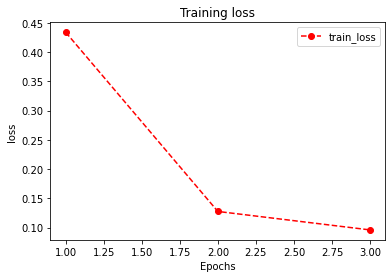

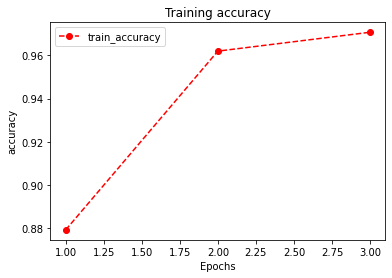

In [12]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs =range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'ro--')
    # 相关属性
    plt.title('Training ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric])
    plt.show()
    
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

## 4. 模型预测

验证 model 是否成功训练，用 test 数据集进行推理

[[9.9996626e-01 1.4769049e-11 9.2003684e-06 1.7467864e-08 4.9978299e-11
  2.7343510e-06 1.8248045e-05 2.1739025e-08 3.5199512e-06 4.2335028e-08]]


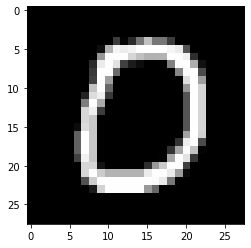

predict : 0
[[2.8009330e-05 4.5321844e-11 9.7381196e-09 5.0684776e-09 4.5673523e-09
  5.0383019e-08 9.9996769e-01 2.1316653e-10 4.2623492e-06 8.4890415e-09]]


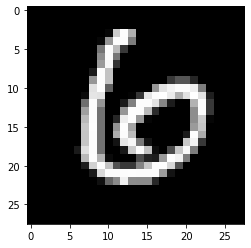

predict : 6
[[2.53224091e-08 1.67729636e-10 4.67048302e-08 6.03133549e-06
  1.08222244e-04 5.97665121e-07 8.42579562e-10 1.19678283e-04
  2.74235281e-05 9.99737918e-01]]


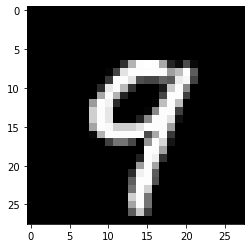

predict : 9
[[9.9971586e-01 4.3643675e-10 4.7211092e-06 1.1431029e-07 2.3265642e-08
  2.4527574e-06 1.4930686e-05 1.4385853e-05 1.8678057e-04 6.0687777e-05]]


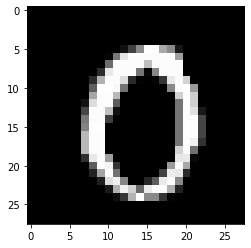

predict : 0
[[2.1558282e-05 9.9960190e-01 2.8774313e-05 4.3574975e-05 2.0877575e-05
  2.0334926e-05 7.4523581e-05 1.2441087e-06 1.8609168e-04 1.0795652e-06]]


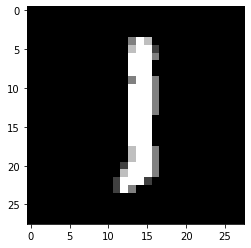

predict : 1
[[1.8830853e-07 5.0542988e-09 4.4923738e-07 2.3900621e-04 4.2977538e-11
  9.9975652e-01 4.5916124e-08 7.4222353e-09 3.5669498e-06 2.3079153e-07]]


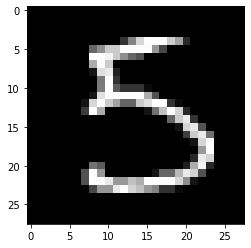

predict : 5


In [13]:
for img in x_test[10:16]:
    y = model.predict(tf.expand_dims(img, axis=0))
    print(y)
    # 获取概率最高的元素的索引
    p = np.argmax(y)
    plt.imshow(img[:, :, 0], cmap="gray")
    plt.show()
    print(f"predict : {p}")

## 5. 模型保存

In [14]:
keras_file = 'test2.h5'
print(keras_file)
model.save(keras_file, save_format="h5")

test2.h5


In [15]:
loss, acc = model.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 0.0717 - accuracy: 0.9787


## 6. 加载保存的模型并预测

In [16]:
# load model and test
model_restore = models.load_model(keras_file)

np.testing.assert_allclose(model.predict(x_test), model_restore.predict(x_test))

In [17]:
# model_restore.summary()

[[1.7815743e-06 5.8743328e-08 5.6611381e-05 5.9076319e-06 4.9270588e-09
  2.5537425e-08 4.5907995e-12 9.9992859e-01 4.9047429e-07 6.4322921e-06]]


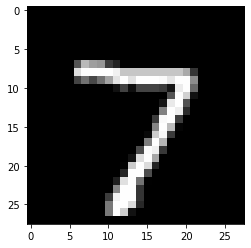

predict : 7
[[7.8274781e-04 1.4364454e-03 9.9738222e-01 3.2859275e-04 7.9750273e-10
  1.5498598e-07 3.2389336e-05 2.5114938e-10 3.7591675e-05 3.4011870e-11]]


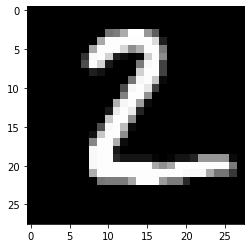

predict : 2
[[1.22010868e-04 9.95616794e-01 2.75858998e-04 6.49976064e-05
  1.90997683e-03 3.23441891e-05 3.16414167e-04 1.11846987e-03
  4.24655678e-04 1.18456206e-04]]


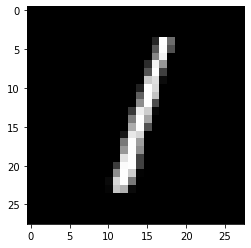

predict : 1
[[9.9830401e-01 1.1025204e-08 3.5028494e-05 9.7914466e-08 1.0304360e-07
  8.7311338e-07 1.6498286e-03 3.9817919e-06 3.2841217e-06 2.6822067e-06]]


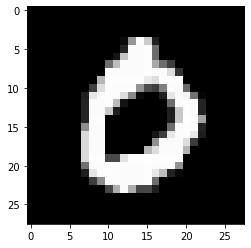

predict : 0
[[5.9993913e-06 2.1169595e-09 9.7252996e-07 6.9156720e-09 9.9992442e-01
  2.1930349e-08 2.7742769e-06 1.0492582e-05 4.8085496e-07 5.4909706e-05]]


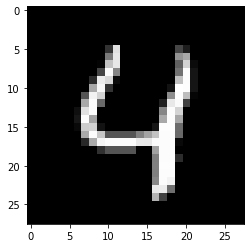

predict : 4
done


In [18]:
for test_image in x_test[:5]:
    y = model_restore.predict(tf.expand_dims(test_image, axis=0))
    #  获取概率最高的元素的索引
    print(y)
    p = np.argmax(y)
    plt.imshow(test_image[:, :, 0], cmap="gray")
    plt.show()
    print(f"predict : {p}")

    test_out = model.predict(tf.expand_dims(test_image, axis=0))
    if not (test_out == y).all():
        print("err")
print("done")